image dimension : 216 x 256, 10개의 슬라이스

0: 배경
1: 초록색
2: 노란색(경계선)
3: 빨간색(내부)

In [1]:
!pip install SimpleITK
!pip install --upgrade torch
!pip install --upgrade torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 42.9 MB/s eta 0:00:00


# frame01.nii 이미지 불러오기

In [6]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

# 상위 디렉토리 경로
base_dir = "/content/drive/MyDrive/medicalAI/training"
output_dir = "/content/drive/MyDrive/medicalAI/output"
os.makedirs(output_dir, exist_ok=True)

# 기준 NIfTI 설정
reference_img_path = os.path.join(base_dir, "patient001", "patient001_frame01.nii")
reference_img = nib.load(reference_img_path)
reference_affine = reference_img.affine  # 방향 및 위치 정보
reference_spacing = reference_img.header.get_zooms()  # voxel spacing
target_shape_hw = (256, 256)  # H, W만 고정

# 크기 조정 함수 (H, W만 고정)
def resize_hw(array, target_shape_hw):
    """배열의 H, W를 target_shape_hw로 리사이즈, Depth는 유지"""
    original_shape = array.shape
    zoom_factors = [
        target_shape_hw[0] / original_shape[0],  # H (Height)
        target_shape_hw[1] / original_shape[1],  # W (Width)
        1.0  # D (Depth)는 그대로 유지
    ]
    resized_array = zoom(array, zoom_factors, order=1)  # 선형 보간법
    return resized_array

# 모든 환자 데이터 처리
all_img_slices = []
all_gt_slices = []

for i in range(1, 101):  # patient001 ~ patient100
    patient_id = f"patient{i:03d}"
    patient_path = os.path.join(base_dir, patient_id)

    if os.path.isdir(patient_path):
        img_path = os.path.join(patient_path, f"{patient_id}_frame01.nii")
        gt_path = os.path.join(patient_path, f"{patient_id}_frame01_gt.nii")

        if os.path.exists(img_path) and os.path.exists(gt_path):
            # .nii 파일 로드
            img = nib.load(img_path)
            gt = nib.load(gt_path)

            img_array = img.get_fdata()
            gt_array = gt.get_fdata()

            # H, W 리사이즈 (Depth는 유지)
            img_resized = resize_hw(img_array, target_shape_hw)
            gt_resized = resize_hw(gt_array, target_shape_hw)

            # 결과 추가
            all_img_slices.append(img_resized)
            all_gt_slices.append(gt_resized)

# 병합
combined_img_slices = np.concatenate(all_img_slices, axis=-1)  # Depth 기준으로 병합
combined_gt_slices = np.concatenate(all_gt_slices, axis=-1)

# 병합된 데이터를 기준 NIfTI의 메타데이터를 사용해 저장
combined_img = nib.Nifti1Image(combined_img_slices, reference_affine)
combined_gt = nib.Nifti1Image(combined_gt_slices, reference_affine)

nib.save(combined_img, os.path.join(output_dir, "combined_img_slices.nii.gz"))
nib.save(combined_gt, os.path.join(output_dir, "combined_gt_slices.nii.gz"))

print("All data combined and saved with consistent H, W and variable Depth.")


All data combined and saved with consistent H, W and variable Depth.
(224, 154, 16)


In [39]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import affine_transform, zoom

# 상위 디렉토리 경로
base_dir = "/content/drive/MyDrive/medicalAI/testing"
output_dir = "/content/drive/MyDrive/medicalAI/output_test"
os.makedirs(output_dir, exist_ok=True)

# 기준 수치 설정
reference_direction = np.array([[-1.0, 0.0, 0.0],
                                 [0.0, -1.0, 0.0],
                                 [0.0,  0.0,  1.0]])  # 방향 기준값
reference_origin = np.array([0.0, 0.0, 0.0])  # 원점 기준값
reference_spacing = np.array([1.5625, 1.5625, 10.0])  # 스페이싱 기준값
target_shape_hw = (256, 256)  # 고정 크기 (H, W)

# 빈 리스트 생성
all_img_slices = []
all_gt_slices = []

# 크기 조정 함수 (H, W만 고정)
def resize_hw(array, original_shape, target_shape_hw):
    """배열의 H, W를 target_shape_hw로 리사이즈, Depth는 유지"""
    zoom_factors = [
        target_shape_hw[0] / original_shape[0],  # H (Height)
        target_shape_hw[1] / original_shape[1],  # W (Width)
        1.0  # Depth는 그대로 유지
    ]
    resized_array = zoom(array, zoom_factors, order=1)  # 선형 보간법
    return resized_array

# 환자 데이터 처리
for i in range(101, 151):  # patient101 ~ patient150
    patient_id = f"patient{i:03d}"
    patient_path = os.path.join(base_dir, patient_id)

    if os.path.isdir(patient_path):
        img_path = os.path.join(patient_path, f"{patient_id}_frame01.nii")
        gt_path = os.path.join(patient_path, f"{patient_id}_frame01_gt.nii")

        if os.path.exists(img_path) and os.path.exists(gt_path):
            try:
                # .nii 파일 로드
                img = nib.load(img_path)
                gt = nib.load(gt_path)

                img_array = img.get_fdata()
                gt_array = gt.get_fdata()
                img_affine = img.affine
                img_spacing = img.header.get_zooms()

                # 1. 방향 변환
                current_direction = img_affine[:3, :3]
                direction_transform = np.linalg.inv(current_direction) @ reference_direction
                transformed_img = affine_transform(img_array, direction_transform)
                transformed_gt = affine_transform(gt_array, direction_transform)

                # 2. 원점 변환
                current_origin = img_affine[:3, 3]
                origin_offset = reference_origin - current_origin
                transformed_img = affine_transform(transformed_img, np.eye(3), offset=origin_offset)
                transformed_gt = affine_transform(transformed_gt, np.eye(3), offset=origin_offset)

                # 3. H, W 크기 조정
                img_resized = resize_hw(transformed_img, transformed_img.shape, target_shape_hw)
                gt_resized = resize_hw(transformed_gt, transformed_gt.shape, target_shape_hw)

                # 리스트에 추가
                all_img_slices.append(img_resized)
                all_gt_slices.append(gt_resized)

                print(f"Processed patient: {patient_id}, Image shape: {img_resized.shape}")

            except Exception as e:
                print(f"Failed to process patient {patient_id}: {e}")

# 병합
if all_img_slices and all_gt_slices:
    combined_img_slices = np.concatenate(all_img_slices, axis=-1)  # Depth 기준으로 병합
    combined_gt_slices = np.concatenate(all_gt_slices, axis=-1)

    # 고정된 메타데이터 생성
    reference_affine = np.eye(4)
    reference_affine[:3, :3] = reference_direction * reference_spacing[:, np.newaxis]
    reference_affine[:3, 3] = reference_origin

    # NIfTI 파일 저장
    combined_img = nib.Nifti1Image(combined_img_slices, reference_affine)
    combined_gt = nib.Nifti1Image(combined_gt_slices, reference_affine)

    nib.save(combined_img, os.path.join(output_dir, "combined_img_slices.nii.gz"))
    nib.save(combined_gt, os.path.join(output_dir, "combined_gt_slices.nii.gz"))

    print("All data combined and saved with consistent direction, origin, and spacing.")
else:
    print("No valid data found to combine.")


[[[19. 20. 18. ... 16. 15. 14.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  

(538, 256, 256)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


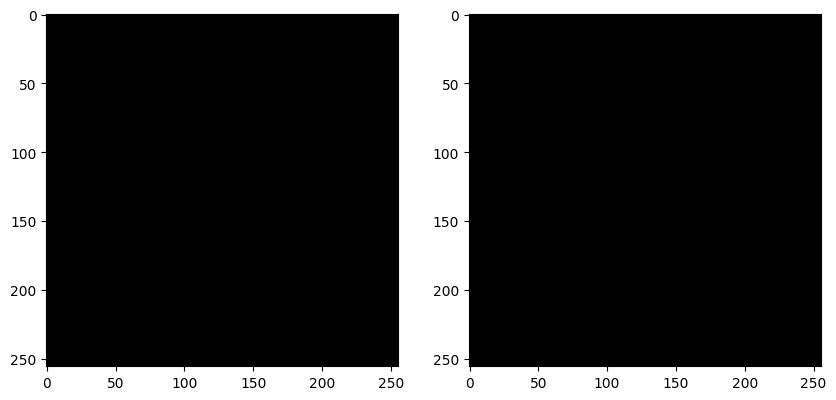

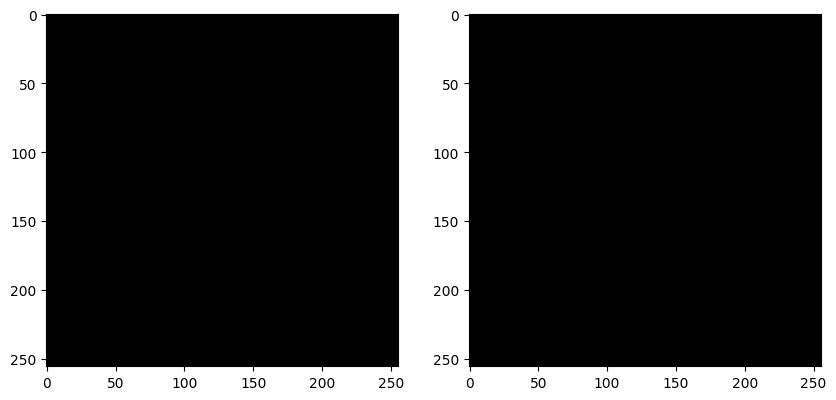

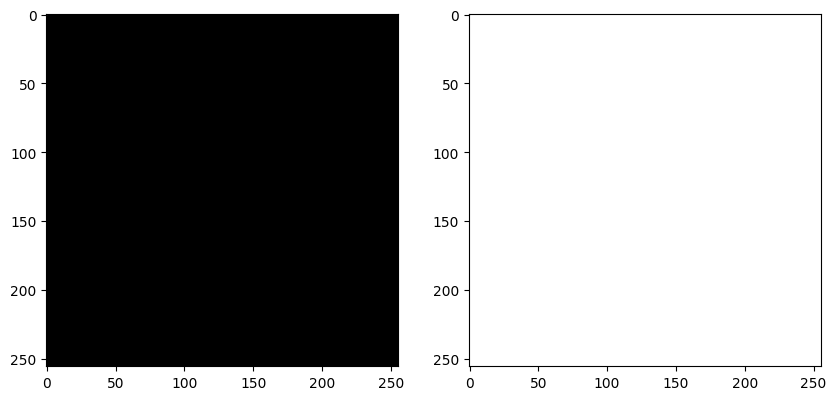

In [40]:
img = sitk.ReadImage("/content/drive/MyDrive/medicalAI/output_test/combined_img_slices.nii.gz")
gt = sitk.ReadImage("/content/drive/MyDrive/medicalAI/output_test/combined_gt_slices.nii.gz")

img_array = sitk.GetArrayFromImage(img)
gt_array = sitk.GetArrayFromImage(gt)

print(img_array.shape)
print(img.GetOrigin())
print(img.GetDirection())

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img_array[0,:,:], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(gt_array[0,:,:], cmap='gray')

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img_array[12,:,:], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(gt_array[12,:,:], cmap='gray')

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img_array[333,:,:], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(gt_array[333,:,:], cmap='gray')

In [13]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 병합된 NIfTI 파일 경로
img_path = "/content/drive/MyDrive/medicalAI/output_test/combined_img_slices.nii.gz"
gt_path = "/content/drive/MyDrive/medicalAI/output_test/combined_gt_slices.nii.gz"

print(reference_affine)
# Affine 행렬 확인
print("Combined Image Affine:\n", combined_img_slices.affine)
print("Combined GT Affine:\n", combined_gt_slices.affine)

# 파일 로드
img_nifti = nib.load(img_path)
gt_nifti = nib.load(gt_path)

# NumPy 배열로 변환
img_data = img_nifti.get_fdata()
gt_data = gt_nifti.get_fdata()

# 데이터 정보 출력
print(f"Image Shape: {img_data.shape}")
print(f"GT Shape: {gt_data.shape}")

# 슬라이스 시각화 함수
def visualize_slices(image, gt, slice_indices):
    """
    이미지와 GT 슬라이스를 시각화.
    :param image: 이미지 데이터 (NumPy 배열)
    :param gt: GT 데이터 (NumPy 배열)
    :param slice_indices: 시각화할 슬라이스 인덱스 리스트
    """
    for idx in slice_indices:
        if idx >= image.shape[2]:  # Depth 범위 초과 방지
            print(f"Slice index {idx} out of range (max: {image.shape[2]-1}). Skipping.")
            continue

        plt.figure(figsize=(12, 6))

        # 이미지 슬라이스
        plt.subplot(1, 2, 1)
        plt.imshow(image[:, :, idx], cmap="gray")
        plt.title(f"Image Slice {idx}")
        plt.axis("off")

        # GT 슬라이스
        plt.subplot(1, 2, 2)
        plt.imshow(gt[:, :, idx], cmap="gray")
        plt.title(f"GT Slice {idx}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# 시각화할 슬라이스 인덱스 선택
slice_indices = [0, img_data.shape[2] // 4, img_data.shape[2] // 2, img_data.shape[2] - 1]  # 첫 번째, 중간 두 개, 마지막 슬라이스

# 슬라이스 시각화
visualize_slices(img_data, gt_data, slice_indices)


[[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


AttributeError: 'numpy.ndarray' object has no attribute 'affine'

(944, 256, 256)
(944, 256, 256)
float64


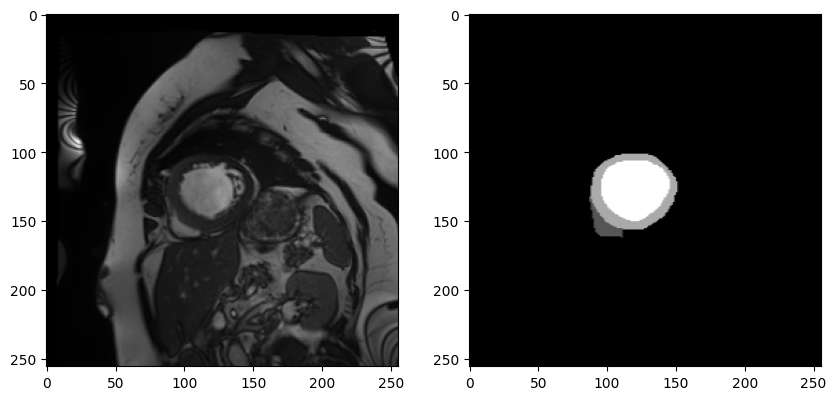

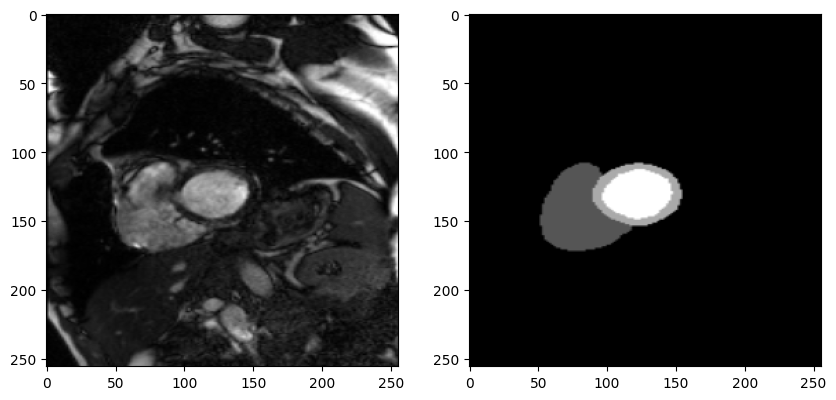

In [11]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/medicalAI/output/combined_img_slices.nii.gz"
gt_path = "/content/drive/MyDrive/medicalAI/output/combined_gt_slices.nii.gz"

img_slices = sitk.ReadImage(img_path)
gt_slices = sitk.ReadImage(gt_path)

img_slices = sitk.GetArrayFromImage(img_slices)
gt_slices = sitk.GetArrayFromImage(gt_slices)

print(img_slices.shape)
print(gt_slices.shape)

print(img_slices.dtype)

#데이터 확인
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_slices[15,:,:],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(gt_slices[15,:,:],cmap="gray")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_slices[920,:,:],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(gt_slices[920,:,:],cmap="gray")

# frame01_gt 이미지 불러오기

(500, 256, 256)
(500, 256, 256)


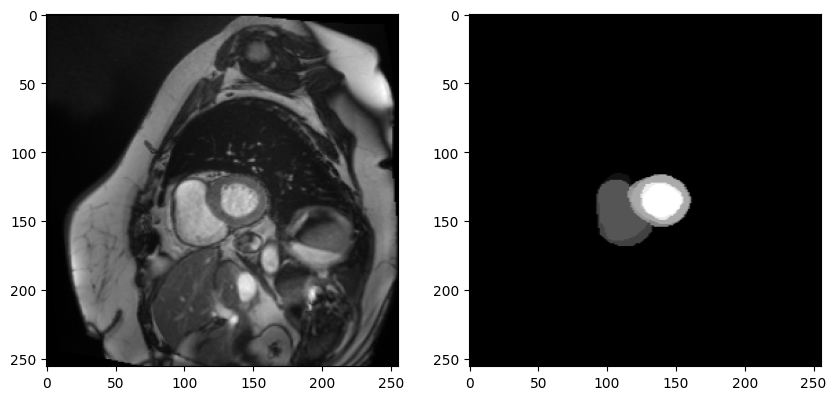

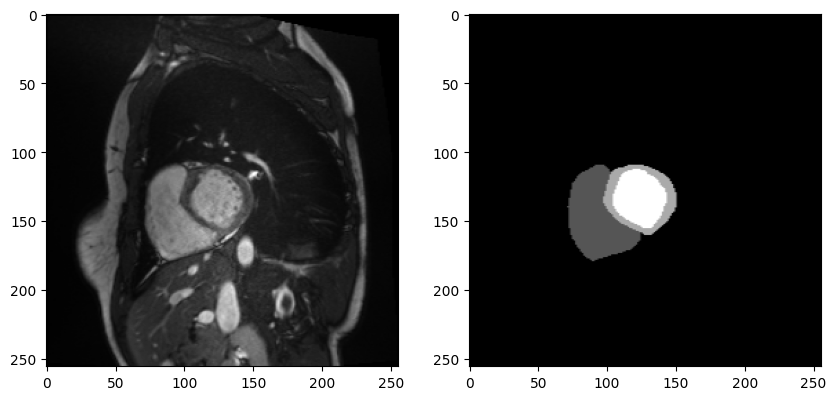

In [3]:
img_path = "/content/drive/MyDrive/medicalAI/output_test/combined_img_slices.nii.gz"
gt_path = "/content/drive/MyDrive/medicalAI/output_test/combined_gt_slices.nii.gz"

img_slices_test = sitk.ReadImage(img_path)
gt_slices_test = sitk.ReadImage(gt_path)

img_slices_test = sitk.GetArrayFromImage(img_slices_test)
gt_slices_test = sitk.GetArrayFromImage(gt_slices_test)

print(img_slices_test.shape)
print(gt_slices_test.shape)

#데이터 확인
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_slices_test[11,:,:],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(gt_slices_test[11,:,:],cmap="gray")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_slices_test[490,:,:],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(gt_slices_test[490,:,:],cmap="gray")

# pytorch tensor로 반환

In [4]:
import torch

# 데이터 타입 확인
print("Image slices dtype:", img_slices.dtype)
print("GT slices dtype:", gt_slices.dtype)

# NumPy 배열을 PyTorch 텐서로 변환(CNN 또는 U-Net)모델은 입력 데이터가 4차원이어야 하기 때문
# 모델 입력: (batch_size, channels, height, width)
img_tensor = torch.tensor(img_slices).unsqueeze(1).float() #unsqueeze(1)로 채널 차원 추가
#모델 입력 데이터는 float 타입이어야 함 -> 연산 및 손실 함수에서 부동소수점 연산이 필요하기 때문

gt_tensor = torch.tensor(gt_slices).unsqueeze(1).long()
#gt 데이터는 손실 함수에서 정수 형태 요구
#클래스 인덱스를 나타내기 때문

img_tensor_test = torch.tensor(img_slices_test).unsqueeze(1).float()
gt_tensor_test = torch.tensor(gt_slices_test).unsqueeze(1).long()

print("img_tensor shape: ",img_tensor.shape)
print("gt_tensor shape: ",gt_tensor.shape)

print("img_tensor_test shape: ",img_tensor_test.shape)
print("gt_tensor_test shape: ",gt_tensor_test.shape)

#[990,1,256,256]
#990 : 배치 크기, 즉 슬라이싱된 990장의 이미지
#1 : 채널 수(흑백이므로)
#256 : 이미지의 h
#256 : 이미지의 w


Image slices dtype: float64
GT slices dtype: float64
img_tensor shape:  torch.Size([990, 1, 256, 256])
gt_tensor shape:  torch.Size([990, 1, 256, 256])
img_tensor_test shape:  torch.Size([500, 1, 256, 256])
gt_tensor_test shape:  torch.Size([500, 1, 256, 256])


# U-Net 모델 정의

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder

        #conv_block(in_channels, out_channels)
        #enc1 : input channel이 1(흑백)
        #점점 더 깊은 레벨로 갈수록 채널 수 증가(다운샘플링) -> 특징 포착 위해
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        #512채널을 입력 받아 1024 채녈로 변환
        #네트워크의 가장 깊은 부분
        self.bottleneck = self.conv_block(512, 1024)


        # Decoder

        #업샘플링 + conv_block
        #upconv : 업샘플링 레이어, 특징 맵의 크기를 2배로 늘림(해상도 복원 위함)
        #stride=2 : 출력 크기가 입력 크기의 2배가 됨
        #self.upconv4 : 1024의 출력을 받아 크기를 2배로 늘리고, 출력 채널을 512로 줄임
        #dec : 결합된 특징 맵을 다시 학습. 점진적으로  최종 해상도를 복원
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output

        #1x1 convloution layer로 출력 채널을 4개로 설정(4개의 클래스로 seg하므로)
        self.final = nn.Conv2d(64, 4, kernel_size=1)  # 4 classes: 0, 1, 2, 3
        print(self.final)

    #두 개의 3x3 convloution layer + ReLU 활성화 함수로 구성
    #padding=1 : 입력 이미지의 크기 유지
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),#채널 변환
            nn.BatchNorm2d(out_channels), #정규화
            nn.ReLU(inplace=True), #활성화함수

            #두 번의 conv 연산(더 복잡한 특징을 학습할 수 있도록 추가 연산)
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),#특징 맵의 정보 학습
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)#과적합 방지용
        )

    def forward(self, x):
        # Encoder

        #각 레이어 사이에서 2x2 Max Pooling으로 다운샘플링(크기 줄이기)
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))

        # Bottleneck

        #인코더의 마지막  출력 enc4를 받아 Bottleneck 레이어를 통과
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        # Decoder

        #업샘플링된 출력 + 대응되는 인코더의 출력 = 결합
        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), self.crop(self.upconv4(bottleneck), enc4)], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), self.crop(self.upconv3(dec4), enc3)], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), self.crop(self.upconv2(dec3), enc2)], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), self.crop(self.upconv1(dec2), enc1)], dim=1))

        # Output

        #4개의 클래스 출력
        return self.final(dec1)

    def crop(self, upsampled, skip): #unsmapled : decoder의 업샘플링된 출력, skip : 스킵 커넥션
        # 인코더의 출력(skip)을 h,w에 맞게 자름
        batch, channel, H, W = upsampled.size()
        skip = skip[:, :, :H, :W]  # H, W 조정
        return skip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))


# 데이터 증강

In [23]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


train_imgs, val_imgs, train_gts, val_gts = train_test_split(
    img_tensor, gt_tensor, test_size=0.3, random_state=42
)

print(train_imgs.shape)
print(val_imgs.shape)

print(train_gts.shape)
print(val_gts.shape)

def augment_data(img_tensor, gt_tensor, augment_factor=2):
    """
    데이터 증강 함수
    img_tensor와 gt_tensor를 입력받아 증강된 데이터를 반환합니다.

    Parameters:
        - img_tensor: [N, 1, H, W] 형태의 이미지 텐서
        - gt_tensor: [N, H, W] 형태의 GT 텐서
        - augment_factor: 각 이미지에 대해 증강할 횟수

    Returns:
        - augmented_img: 증강된 이미지 텐서 [M, 1, H, W]
        - augmented_gt: 증강된 GT 텐서 [M, H, W]
    """
    augmented_img = []
    augmented_gt = []

    # 데이터 증강 작업
    for i in range(train_imgs.shape[0]):  # 각 슬라이스에 대해 반복
        img = train_imgs[i]
        gt = train_gts[i]

        augmented_img.append(img)
        augmented_gt.append(gt)

        # 좌우 반전(수평 뒤집기)
        img_flipped = TF.hflip(img)
        gt_flipped = TF.hflip(gt)
        augmented_img.append(img_flipped)
        augmented_gt.append(gt_flipped)

        '''img_brightness = TF.adjust_brightness(img, brightness_factor=1.2)
        augmented_img.append(img_brightness)
        augmented_gt.append(gt)  # GT는 변하지 않음

        # 회전
        for angle in [45, 90]:
            img_rotated = TF.rotate(img, angle)
            gt_rotated = TF.rotate(gt, angle)
            augmented_img.append(img_rotated)
            augmented_gt.append(gt_rotated)

###노이즈 추가 주로 많이 사용(random.transformation)
        # 노이즈 추가
                for noise_level in [0.01, 0.03]:
                noise = torch.randn_like(img) * noise_level
                img_noisy = img + noise
                augmented_img.append(img_noisy)
                augmented_gt.append(gt)'''

    # 모든 텐서를 동일한 크기로 맞추기
    standard_size = (256, 256)  # 기준 크기

    # 이미지 증강 리스트 정규화
    augmented_img = [F.interpolate(img.unsqueeze(0), size=standard_size, mode='bilinear', align_corners=False).squeeze(0) for img in augmented_img]

    # GT 데이터 처리 (Float으로 변환 후 보간, 이후 Long으로 다시 변환)
    augmented_gt = [F.interpolate(gt.unsqueeze(0).float(), size=standard_size, mode='nearest').squeeze(0).long() for gt in augmented_gt]

    # 리스트를 하나의 텐서로 변환
    augmented_img = torch.stack(augmented_img)  # [N, 1, 256, 256]
    augmented_gt = torch.stack(augmented_gt)  # [N, 256, 256]

    return augmented_img, augmented_gt


# 원본 train 및 validation 데이터
# train_img_tensor와 train_gt_tensor는 [N, 1, H, W], [N, H, W] 형태의 원본 데이터
# val_img_tensor와 val_gt_tensor는 [N, 1, H, W], [N, H, W] 형태의 원본 데이터

# 데이터 증강 함수 호출
augmented_img, augmented_gt = augment_data(img_tensor, gt_tensor, augment_factor=2)

train_imgs, train_gts = augmented_img, augmented_gt

# 데이터 크기 확인
print(f"Augmented images: {train_imgs.shape}")
print(f"Augmented GTs: {train_gts.shape}")

# Ground Truth에서 클래스별 개수 확인
unique_classes, class_counts = torch.unique(train_gts, return_counts=True)

print(class_counts)


# 전체 GT 클래스 분포 확인
#gt_classes = torch.unique(augmented_gt, return_counts=True)
#print(f"GT Classes: {gt_classes}")

torch.Size([693, 1, 256, 256])
torch.Size([297, 1, 256, 256])
torch.Size([693, 1, 256, 256])
torch.Size([297, 1, 256, 256])
Augmented images: torch.Size([1386, 1, 256, 256])
Augmented GTs: torch.Size([1386, 1, 256, 256])
tensor([86892864,  1504048,  1081618,  1354366])


#가중치 부여, loss들  정의

In [24]:
#model, loss function, optimizer define

print(device)

# Class별 가중치 부여
#310470699,   5353772,   3847096,   4731633
class_counts = torch.tensor([86892864 ,  1504048,  1081618,  1354366 ], dtype=torch.float32, device='cuda')
class_weights = 1.0 / torch.sqrt(class_counts)
#개수가 많은 것들의 가중치가 적게 부여되도록

print(class_weights)

class_weights /= class_weights.sum() #정규화
print(class_weights)
print(f"Class Weights: {class_weights}")

#crossentropyloss로 정의
#weight = class_weights

#####모든 조건이 동일해야 함
func = nn.CrossEntropyLoss(weight = class_weights)
func_val = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


##FP/TN 볼 수 있는 , f1-score, AUC , precision recall, ppv fpv(pair로)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)  # 10 Epoch마다 학습률 감소
#num_classes=4 : 클래스 수 설정
#dice_score_metric = MulticlassDiceScore(num_classes=4).to(device)

#dice_score 정의
#Dice Score = (2 * |X ∩ Y|) / (|X| + |Y|)
def dice_score(X, Y):
    smooth = 1e-6

    # 모델 출력이 [batch_size, num_classes, height, width]인 경우, argmax로 변환
    if len(X.shape) == 4:
        X = torch.argmax(X, dim=1)  # [batch_size, height, width]

    X_flat = X.contiguous().view(-1)
    Y_flat = Y.contiguous().view(-1)
    intersection = (X_flat * Y_flat).sum()

    return ((2. * intersection + smooth) / ((X_flat+Y_flat).sum() + smooth))




cuda
tensor([0.0001, 0.0008, 0.0010, 0.0009], device='cuda:0')
tensor([0.0391, 0.2972, 0.3505, 0.3132], device='cuda:0')
Class Weights: tensor([0.0391, 0.2972, 0.3505, 0.3132], device='cuda:0')


#train, val로 분할

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


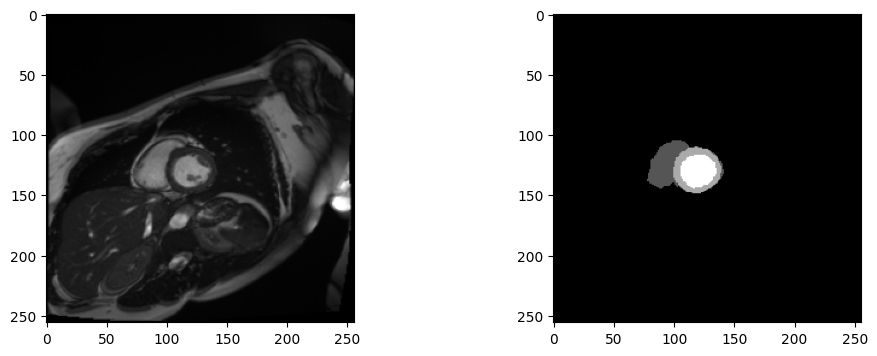

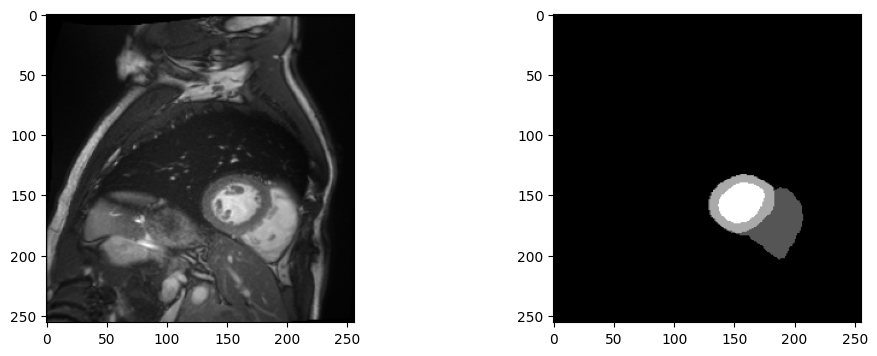

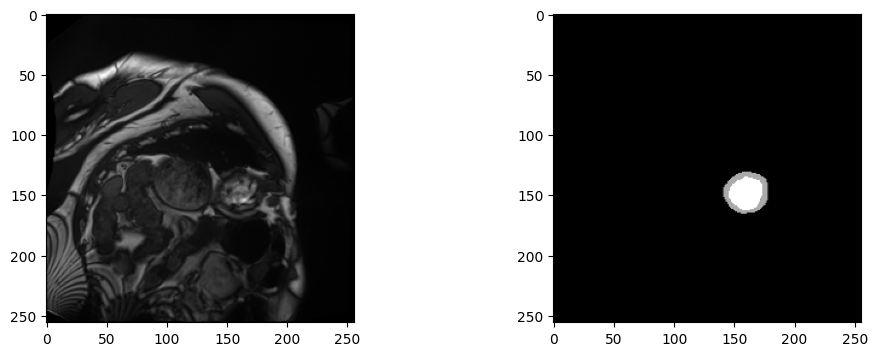

Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))


In [25]:
import torch, torchmetrics
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

#from torchmetrics.functional import dice_score
#from torchmetrics.classification import MulticlassDiceScore


#입력 데이터와 해당 레이블을 쌍(pair)으로 묶어서 하나의 데이터셋으로 만듦
#각 샘플을 (입력 데이터, 레이블) 형태로 반환
train_dataset = torch.utils.data.TensorDataset(train_imgs, train_gts)
val_dataset = torch.utils.data.TensorDataset(val_imgs, val_gts)
#train_dataset[0] : (img, gt)반환

#데이터셋 반복(iteration) 도구

#######, transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)


# 첫 번째 배치 데이터 가져오기
data_iter = iter(train_loader)
batch_imgs, batch_gts = next(data_iter)
print(batch_imgs.shape)
print(batch_gts.shape)

# 시각화 (3개의 데이터 샘플을 그려보기)
for i in range(3):  # 3개 데이터 샘플 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(batch_imgs[i+3, 0], cmap="gray")

    plt.subplot(1, 2, 2)
    plt.imshow(batch_gts[i+3].squeeze(0), cmap="gray")

    plt.show()



#model, loss function, optimizer define
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)




# 모델 학습

In [26]:
import torch.nn.functional as F

# Training loop with overfitting prevention
prior_dice_score = 0.0
early_stopping_counter = 0 #개선되지 않은 에포크 수 기록

train_crossentropy_losses = []
train_dice_scores = []

val_crossentropy_losses = []
val_dice_scores = []


for epoch in range(30):
    model.train()
    total_dice_score=0.0
    total_crossentropy_loss= 0.0
    all_dice_scores=[]


    for imgs, gts in train_loader:
      imgs = imgs.to(device, non_blocking=True)  # GPU로 빠른 전송
      gts = gts.squeeze(1).long().to(device, non_blocking=True)
      #각각의 train_loader마다 img, gt 불러오기

      #print(imgs.shape)
      #print(gts.shape)

      # Forward pass
      outputs = model(imgs)

      #outputs과 gts의 크기 맞추기
      #outputs = F.interpolate(outputs, size=gts.shape[1:], mode="bilinear", align_corners=False)

      #예측값과 gt 간의 일치도 확인(dice_score, crossentropy_loss)
      dice_score_value = dice_score(outputs, gts)
      crossentropy_loss = func(outputs, gts)

      # Backward pass(역전파)
      optimizer.zero_grad()
      crossentropy_loss.backward() #가중치 계산
      optimizer.step() #가중치 업데이트

      total_crossentropy_loss += crossentropy_loss.item()
      total_dice_score += dice_score_value.item()

    # 스케줄러 업데이트
    scheduler.step()

    #batch별 평균값 계산
    epoch_loss = total_crossentropy_loss / len(train_loader)
    epoch_dice = total_dice_score / len(train_loader)

    # 기록 저장
    train_crossentropy_losses.append(epoch_loss)
    train_dice_scores.append(epoch_dice)

    print(f"{epoch+1}번째 dice_score : {total_dice_score / len(train_loader):.4f}")
    print(f"{epoch+1}번째 crossentropy loss : {total_crossentropy_loss / len(train_loader):.4f}")
    #mean_train_dice_score = torch.stack(all_dice_scores).mean(dim=0)
    #print(mean_train_dice_score.tolist())
    #augmented_gt, return_counts=True

    #predicted_batch = torch.argmax(outputs, dim=1)
    #print("Predicted Classes:", torch.unique(predicted_batch))
    #예측된 클래스 종류만 출력

    # Validation phase
    model.eval()
    total_val_dice_score = 0.0
    total_val_crossentropy_loss = 0.0

    with torch.no_grad():  # Validation은 gradient 계산 없음
        for val_imgs, val_gts in val_loader:
            val_imgs = val_imgs.to(device)
            val_gts = val_gts.squeeze(1).long().to(device)

            # Forward pass
            outputs_val = model(val_imgs)

            # 크기 맞추기
            #outputs_val = F.interpolate(outputs_val, size=val_gts.shape[1:], mode="bilinear", align_corners=False)

            # Loss 계산
            dice_score_value_val = dice_score(outputs_val, val_gts)
            crossentropy_loss_val = func_val(outputs_val, val_gts)

            # Metric 누적
            total_val_crossentropy_loss += crossentropy_loss_val.item()
            total_val_dice_score += dice_score_value_val.item()

    # Batch 평균 계산
    avg_val_loss = total_val_crossentropy_loss / len(val_loader)
    avg_val_dice_score = total_val_dice_score / len(val_loader)

    val_crossentropy_losses.append(avg_val_loss)
    val_dice_scores.append(avg_val_dice_score)

    print(f"{epoch+1}번째 Validation Dice Score: {avg_val_dice_score:.4f}")
    print(f"{epoch+1}번째 Validation Crossentropy Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_dice_score >= prior_dice_score:
        print(f"Validation Dice Score improved: {prior_dice_score:.4f} -> {avg_val_dice_score:.4f}")
        prior_dice_score = avg_val_dice_score
        early_stopping_counter = 0
        print("---------------------------------")
    else:
        early_stopping_counter += 1
        print(f"Early stopping patience: {early_stopping_counter}/3")
        print("---------------------------------")
        if early_stopping_counter >= 3:
            print("Early stopping completed")
            break


1번째 dice_score : 0.1609
1번째 crossentropy loss : 1.5585
1번째 Validation Dice Score: 0.1439
1번째 Validation Crossentropy Loss: 1.5209
Validation Dice Score improved: 0.0000 -> 0.1439
---------------------------------
2번째 dice_score : 0.1611
2번째 crossentropy loss : 1.5581
2번째 Validation Dice Score: 0.1444
2번째 Validation Crossentropy Loss: 1.5207
Validation Dice Score improved: 0.1439 -> 0.1444
---------------------------------
3번째 dice_score : 0.1609
3번째 crossentropy loss : 1.5593
3번째 Validation Dice Score: 0.1450
3번째 Validation Crossentropy Loss: 1.5156
Validation Dice Score improved: 0.1444 -> 0.1450
---------------------------------
4번째 dice_score : 0.1607
4번째 crossentropy loss : 1.5580
4번째 Validation Dice Score: 0.1440
4번째 Validation Crossentropy Loss: 1.5133
Early stopping patience: 1/3
---------------------------------
5번째 dice_score : 0.1605
5번째 crossentropy loss : 1.5607
5번째 Validation Dice Score: 0.1426
5번째 Validation Crossentropy Loss: 1.5163
Early stopping patience: 2/3
---------

# loss 변화 그래프

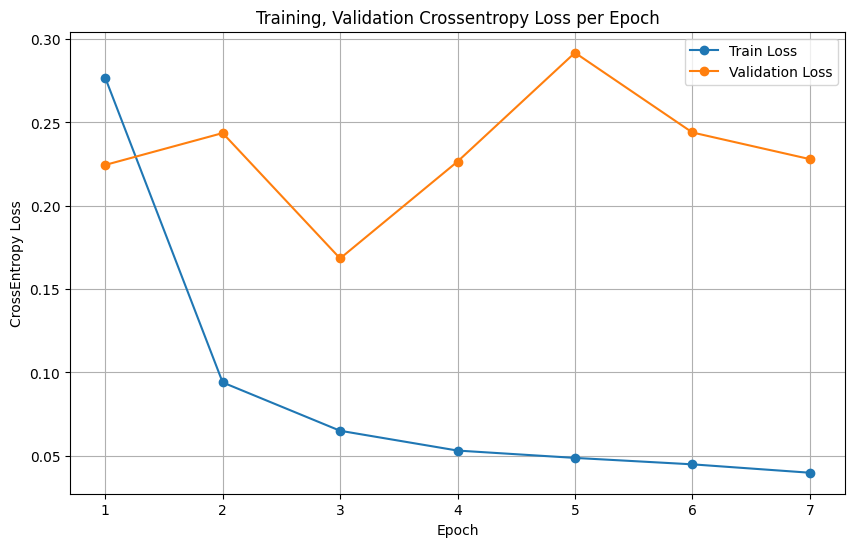

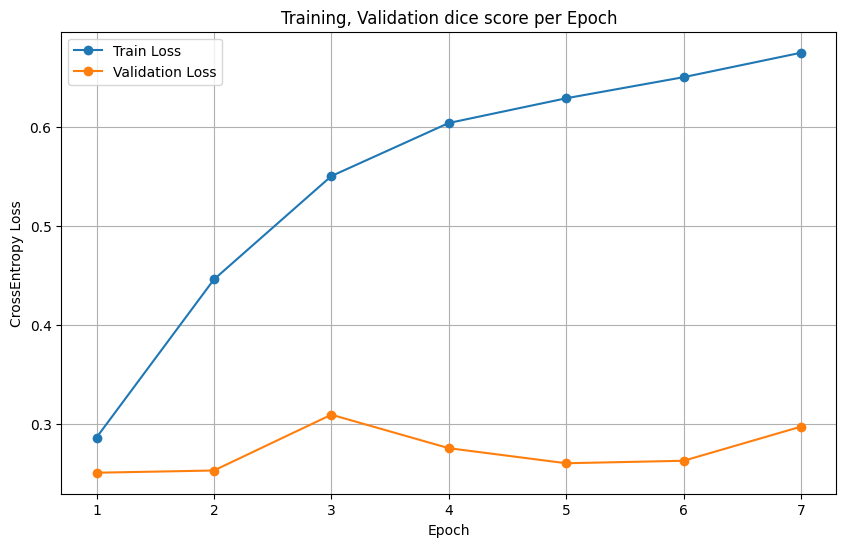

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_crossentropy_losses) + 1)  # 에포크 번호

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_crossentropy_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_crossentropy_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("Training, Validation Crossentropy Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_dice_scores, label="Train Loss", marker="o")
plt.plot(epochs, val_dice_scores, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("Training, Validation dice score per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 모델 평가

In [ ]:
# Test 데이터 준비
test_dataset = torch.utils.data.TensorDataset(img_tensor_test, gt_tensor_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Testing loop
model.eval()
total_dice_score=0.0
total_crossentropy_loss= 0.0
test_dice_scores=[]

with torch.no_grad(): #모델의 가중치 업데이트 안할 때만
    for imgs, gts in test_loader:
        #print(imgs.shape)
        #print(gts.shape)
        imgs = imgs.to(device)
        gts =  gts.squeeze(1).long().to(device)
        #print(imgs.shape)
        #print(gts.shape)

        # Forward pass
        outputs = model(imgs) #예측 결과 얻기

        #interpolate로 outputs과 gts의 크기 맞추기
        outputs = nn.functional.interpolate(outputs, size=gts.shape[1:], mode="bilinear", align_corners=False)

        #print(outputs.shape)

        dice_score_value = dice_score(outputs, gts)
        crossentropy_loss = func_val(outputs, gts)

        total_crossentropy_loss += crossentropy_loss.item()
        total_dice_score += dice_score_value.item()

print(f"final dice_score : {total_dice_score / len(test_loader):.4f}")
print(f"final crossentropy loss : {total_crossentropy_loss / len(test_loader):.4f}")


final dice_score : 0.2810
final crossentropy loss : 0.2662


# 새로운 test 데이터로 예측 , GT와 비교해 성능 비교

torch.Size([1, 1, 256, 256])
torch.Size([256, 256])


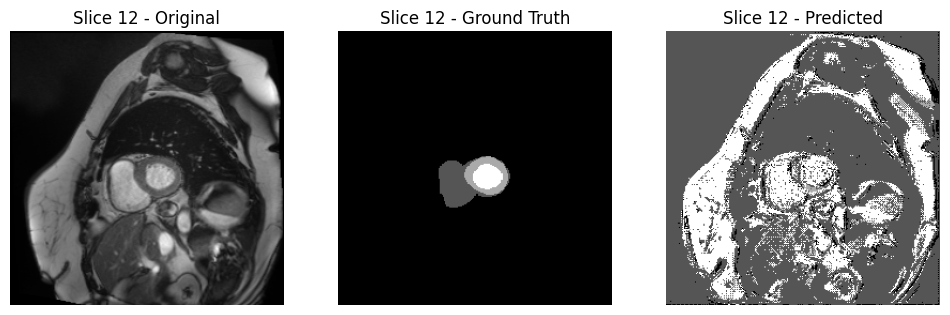

In [22]:
# Test 데이터에서 원하는 인덱스의 데이터 가져오기
index = 11

test_img = img_tensor_test[index].unsqueeze(0).to(device)  # [1, 1, H, W]로 차원 추가
test_gt = gt_tensor_test[index].squeeze(0).to(device)  # [H, W]

print(test_img.shape)
print(test_gt.shape)

# 모델 예측
with torch.no_grad():
    test_output = model(test_img)  # [1, num_classes, H, W]
    test_output = F.interpolate(test_output, size=(test_gt.shape[0], test_gt.shape[1]), mode="bilinear", align_corners=False)
    predicted = torch.argmax(test_output, dim=1).squeeze(0)  # [H, W]

# 시각화 (Original, Ground Truth, Predicted 비교)
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(test_img[0, 0].cpu(), cmap="gray")  # 첫 번째 채널의 이미지를 시각화
plt.title(f"Slice {index + 1} - Original")
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(test_gt.cpu(), cmap="gray")
plt.title(f"Slice {index + 1} - Ground Truth")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted.cpu(), cmap="gray")
plt.title(f"Slice {index + 1} - Predicted")
plt.axis("off")

plt.show()